In [124]:
import pandas as pd 
import numpy as np 
import os as os
from datetime import datetime
import json
import gzip
import jsonlines
import pickle

#### User defined functions:

In [125]:
def writeall_jsonl_gz(filename, payload ):
    with gzip.open(filename, 'wb') as fp:
        json_writer = jsonlines.Writer(fp)
        json_writer.write_all(payload)

### File locations :  

In [126]:
## location to save all created files 
save_folder =  "D:/Samagra/KO/Recommendations engine/IVRS transformations/"

## Location to pick up data from 
folder_loc = "D:/Samagra/KO/Ama_krushi_data/"
file_list = os.listdir(folder_loc)
file_list.reverse()

## variable used to name ids later. This is to show that the data covered is from 2022 Jan to 2022 Feb in the ranking and interaction terms 
time_month = '2022_01_01-2022_02_28_'

## file name for the csv containing all the interactions for the month
interactions_csv_name =  'jan_feb_interaction_rank.csv'

## file name for the gzip with both ranking and interactions: 

gzip_filename_interactions = 'interaction_Jan_Feb.jsonl.gz'

gzip_filename_ranking = 'ranking_Jan_Feb.jsonl.gz'

gzip_filename = 'ranking_interaction_Jan_Feb.jsonl.gz'

## file name for content metdata:  
content_md_filename=  'content_metadata.csv'

### Reading data : 

In [127]:
## reading the content metadata file 
content_md = pd.read_csv(save_folder + content_md_filename )

In [128]:
## initializing table to pull data from the 9 files about for all interactions within Jan-Feb
all_files_df= pd.DataFrame( columns = ['call_datetime', 'pushcall_id', 'number', 'duration', 'ratings', 'pushcall_length'])

##### Pulling data from all files containing interaction data from Jan-Feb 2022

In [129]:
for file_name in file_list[4:10]:
    print(file_name)
    df = pd.read_csv(folder_loc+file_name)
    df = df.loc[~df.pushcall_length.isna(),:]
    df = df[['call_datetime', 'pushcall_id', 'number', 'duration', 'ratings', 'pushcall_length']]
    #all_files_content =  all_files_content.append(content_df,ignore_index= True)
    all_files_df =  pd.concat((all_files_df,df),axis = 0,ignore_index= True)
    

22-02-30_Feb_22_3.csv
22-02-20_Feb_22_2.csv
22-02-10_Feb_22_1.csv
22-01-30_Jan_20-30.csv
22-01-20_Jan_11-20.csv


C:\Users\gauta\AppData\Local\Temp\ipykernel_22988\1566041654.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder_loc+file_name)


22-01-11_Jan_1-10.csv


C:\Users\gauta\AppData\Local\Temp\ipykernel_22988\1566041654.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder_loc+file_name)


In [130]:
all_files_df.shape

(10537786, 6)

In [131]:
df1= all_files_df.copy()

### Table Cleaning:  
- Converting all names to lower case
- Removing na values for duration of content
- Keeping only relevant content (joining with content metadata file) 
- Calculating engagement ratio:  duration of call / length of content

In [132]:
df1['pushcall_id'] =  df1['pushcall_id'].str.lower()
df1 = df1.loc[~df1.pushcall_length.isna(),:]
df1 =  pd.merge(df1,content_md[['pushcall_id']],how='inner')
df1['eng_ratio'] = df1['duration']/df1['pushcall_length']
eng_ratio_cutoff = 0.858034321372855
df1['eng_ratio']= df1.eng_ratio.astype('float')

##### Histogram of engagement ratio:
We can see a clear spike in the frequency of engagment ratio after 1 

With clustering earlier, we arrived at a value of 0.858034321372855 as the cutoff for deciding if the call was good or not. 


array([[<AxesSubplot:title={'center':'Engagement ratio histogram'}>]],
      dtype=object)

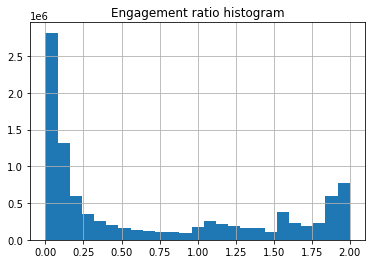

In [133]:
pd.DataFrame(df1['eng_ratio'].values,columns = ['Engagement ratio histogram']).hist( bins = 25)

#### Creating interactions dataframe : 
We filter only for those users who have liked at least one call across the 2 months.

In [134]:
df1.loc[:,'liked_call'] = 0
df1.loc[df1.eng_ratio > eng_ratio_cutoff ,'liked_call'] = 1
numbers_who_liked = np.unique(df1.loc[df1.liked_call == 1,'number' ].values)
numbers_who_liked_df = pd.DataFrame(numbers_who_liked,columns =['number'])

In [135]:
df2 = pd.merge(df1,numbers_who_liked_df)

In [136]:
df2.number.nunique()

1006581

In [137]:
print( 'We see that we have covered',round(df2.number.nunique()/df1.number.nunique()*100,2),'% of users who have liked at least 1 call.')

We see that we have covered 68.87 % of users who have liked at least 1 call.


#### Looking at how many calls these users listened to : 

In [138]:
df_mean = df2.groupby('number').agg( number_calls = ('liked_call','size'), liked_calls = ('liked_call','sum') ).reset_index()
average_calls = round(df_mean.number_calls.mean(),2)
percentage_liked_from_listed = round((df_mean.liked_calls/df_mean.number_calls).mean()*100,2)

In [139]:
print("We see on average that the users listened to ",average_calls,"calls. These users on average liked ",percentage_liked_from_listed," % of the calls." )

We see on average that the users listened to  7.92 calls. These users on average liked  54.1  % of the calls.


In [140]:
del(df_mean)

### Additional table transformations: 

- Ordering the table by time of interactions to get correct order of content shown to the user
- Converting content name to lower case and calculating month of interaction
- Converting user name to string

In [141]:
df2 = df2.sort_values('call_datetime').reset_index(drop= True)

In [142]:
df2['month'] = df2['call_datetime'].str[5:7].astype('int')
df2['pushcall_id'] = df2['pushcall_id'].str.lower()

### Getting the list of items for ranking:

In [143]:
df3 = df2.groupby(['number'])['pushcall_id'].agg([(lambda x: ','.join(map(str, x)))]).applymap(lambda elements: ','.join(set(elements.split(',')))).reset_index().rename(columns = {'<lambda>':'Pushcall_ids_rankings'})

In [144]:
### Change name and run the below 
df3.to_csv(save_folder + interactions_csv_name, index = False)

### Creating ranking and interactions table:

- Adding the ranking column created above to each interaction to get the ranking for each interaction
- Filtering only for the interaction where the user has liked the content. The other interactions go into the ranking column 

In [145]:
rankings_interactions_df =  pd.merge(df2.loc[df2.liked_call ==1 ,:],df3)

In [146]:
df4 = rankings_interactions_df

### Creating the interactions dictionary :  
- Timestamp is calcualted by converting the timestamp to epoch time 
- id is created by including time_month variable created in the beginning (which tells us which months are covered) to the index of the table 
- ranking id is same as interactions id 
- Session and user id are the same 

In [147]:
interactions_df =  df4.copy()

In [148]:
interactions_df = interactions_df[['number','call_datetime','pushcall_id']].rename(columns = {'pushcall_id':'item', 'call_datetime':'timestamp','number':'user'})

In [149]:
interactions_df['user'] =   interactions_df['user'].astype(str).str[0:10]

In [150]:
interactions_df['fields'] = np.empty((len(interactions_df), 0)).tolist()
interactions_df['timestamp'] = ((pd.to_datetime(interactions_df['timestamp']) -  pd.Timestamp("1970-01-01"))/ pd.Timedelta('1s'))* 1000
interactions_df['timestamp']=  pd.to_numeric(interactions_df['timestamp'].astype('str').str[0:13]).astype(object)
interactions_df['id']=  (time_month + interactions_df.index.astype('str')).astype('str')
interactions_df['ranking'] = interactions_df['id']
interactions_df['tenant']= 'default'
interactions_df['type'] =  'click'
interactions_df['session'] = interactions_df['user']
interactions_df['event'] = 'interaction'
interactions_df =  interactions_df[['event','fields','id','item','ranking','session','tenant','timestamp','type','user']]

In [151]:
interactions_dict = interactions_df.to_dict('records')

In [152]:
interactions_dict[1:5]

[{'event': 'interaction',
  'fields': [],
  'id': '2022_01_01-2022_02_28_1',
  'item': '20220102_pr_rabi_paddy_line_sowing_transplanting_crop',
  'ranking': '2022_01_01-2022_02_28_1',
  'session': '9178991774',
  'tenant': 'default',
  'timestamp': 1641998102505,
  'type': 'click',
  'user': '9178991774'},
 {'event': 'interaction',
  'fields': [],
  'id': '2022_01_01-2022_02_28_2',
  'item': '20220102_animal_goat_sheep_bm_livestock',
  'ranking': '2022_01_01-2022_02_28_2',
  'session': '9178991774',
  'tenant': 'default',
  'timestamp': 1642508097184,
  'type': 'click',
  'user': '9178991774'},
 {'event': 'interaction',
  'fields': [],
  'id': '2022_01_01-2022_02_28_3',
  'item': '20220202_animal_goat_sheep_dm_livestock',
  'ranking': '2022_01_01-2022_02_28_3',
  'session': '9178991774',
  'tenant': 'default',
  'timestamp': 1645280123922,
  'type': 'click',
  'user': '9178991774'},
 {'event': 'interaction',
  'fields': [],
  'id': '2022_01_01-2022_02_28_4',
  'item': '20211204_animal_

### Creating the ranking  dictionary :  
- Timestamp is calcualted by converting the timestamp to epoch time and subtracting 10000 milliseconds from it. Ranking needs to be seen before interactions  
- id is created by including time_month variable created in the beginning. Same as the id for interactions
- Session and user id are the same 
- Items is a list of dictinoary of the items provided in the ranking column

In [153]:
rankings_df = df4[['number','call_datetime','Pushcall_ids_rankings']].copy().rename(columns = {'Pushcall_ids_rankings':'items', 'call_datetime':'timestamp','number':'user'})

In [154]:
rankings_df['user'] =  rankings_df['user'].astype(str).str[0:10]

In [155]:
rankings_df['id'] = (time_month + rankings_df.index.astype('str')).astype('str')
rankings_df['event']= 'ranking'
rankings_df['session']= rankings_df['user']
rankings_df['tenant']= 'default'
rankings_df['fields'] = np.empty((len(rankings_df), 0)).tolist()
rankings_df['timestamp'] = ((pd.to_datetime(rankings_df['timestamp']) -  pd.Timestamp("1970-01-01"))/ pd.Timedelta('1s'))* 1000
rankings_df['timestamp'] =  rankings_df['timestamp'] - 10 * 1000
rankings_df['timestamp'] = pd.to_numeric(rankings_df['timestamp'].astype('str').str[0:13]).astype(object)

In [156]:
rankings_df['items']  =("[{'id':'" + rankings_df['items'].str.replace(',',"""','relevancy':0},{'id':'""") + "','relevancy':0}]" ).str.replace("'",'"')

In [157]:
rankings_df['items']  = rankings_df['items'].apply(json.loads)

In [158]:
rankings_dict =  rankings_df.to_dict('records')

### Combining the interactions and ranking json files and feeding it into a gzip file :  

In [159]:
## Make sure don't overwrite old file. Rename gzip_filename

#events_list =  []
#events_list.extend(rankings_dict)
#events_list.extend(interactions_dict)

##saving the created events: 

#payload  = events_list

#writeall_jsonl_gz(save_folder + gzip_filename, payload )

In [ ]:
## saving rankings in gzip
payload = rankings_dict
writeall_jsonl_gz(save_folder + gzip_filename_ranking, payload )

In [ ]:
## saving interactions in gzip
payload = interactions_dict
writeall_jsonl_gz(save_folder + gzip_filename_interactions, payload )

### WIP

In [ ]:

# with open('save_folder' + 'rankings_dic_Jan_Feb.pickle', 'wb') as handle:
#     pickle.dump(rankings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

# with open('save_folder' + 'interactions_dic_Jan_Feb.pickle', 'wb') as handle:
#     pickle.dump(interactions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### writing all into one gzip

In [ ]:
# with open('save_folderitems_dic_Jan_Feb.pickle', 'rb') as handle:
#     items_dic = pickle.load(handle)